In [1]:
from nltk import word_tokenize
import nltk
import re
import pandas as pd

/usr/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


# OBTENÇÃO DOS DADOS

In [108]:
dataset = pd.read_csv('../data/.csv', encoding='UTF-8')
del dataset['Geo Coordinates.latitude']
del dataset['Geo Coordinates.longitude']
del dataset['Created At']
del dataset['Unnamed: 0']
del dataset['User Location']
del dataset['User Screen Name']
del dataset['Username']
del dataset['Retweet Count']
del dataset['Observação']
del dataset['Unnamed: 10']
del dataset['Unnamed: 11']
del dataset['Unnamed: 12']
del dataset['Unnamed: 13']
del dataset['Unnamed: 14']
del dataset['Unnamed: 15']
del dataset['Unnamed: 16']
del dataset['Unnamed: 17']
del dataset['Unnamed: 18']
del dataset['Unnamed: 19']
del dataset['Unnamed: 20']
del dataset['Unnamed: 21']
del dataset['Unnamed: 22']
del dataset['Unnamed: 23']
del dataset['Unnamed: 24']
dataset[:5]

,Text,Classificacao
0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro
1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro
2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro
3,��� https://t.co/BnDsO34qK0,Neutro
4,��� PSOL vai questionar aumento de vereadores ...,Negativo


In [3]:
depurate_tweets = pd.read_pickle('../data/depurate_tweets.pkl')
depurate_tweets[:5]

,date,news,polarity_new,news_keywords,tweets,normalized_tweets,polarity_tweets
0,2019-10-01,[[PF emite certidão à Justiça para dizer que L...,None,"(lava, jato)",1399 Lava Jato cobra multa de R$ 5 milhões ...,"1399 [lava, jato, cobra, multa, de, r, 5, m...",None
1,2019-10-02,"[[Para Maia, derrota em abono não significa pe...",None,"(reforma, previdência)",1398 Economia com reforma da Previdência de...,"1398 [economia, com, reforma, da, previdênc...",None
2,2019-10-03,[[Flávia Boggio | Acho impossível esconder a i...,None,"(pacote, anticrime)",1399 Governo Federal lança campanha publici...,"1399 [governo, federal, lança, campanha, pu...",None
3,2019-10-04,[[Camargo processa ex-executivo por desvio mil...,None,"(lava, jato)",1399 # BRASIL: Los fiscales justicieros del...,"1399 [brasil, los, fiscales, justicieros, d...",None
4,2019-10-05,"[[Desde janeiro, o jornal tem uma editoria de ...",None,"(conselhos, tutelares)",1399 Invasão da Universal ameaça aparelhar ...,"1399 [invasão, da, universal, ameaça, apare...",None


In [4]:
dataset.drop_duplicates(['Text'], inplace=True)
tweets = dataset['Text']
classes = dataset['Classificacao']

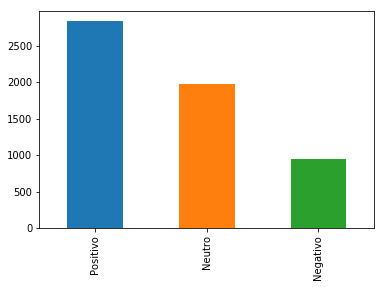

In [5]:
%matplotlib inline
dataset.Classificacao.value_counts().plot(kind='bar')

# PREPROCESSAMENTO DOS TWEETS CLASSIFICADOS

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/igorecarvalho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /home/igorecarvalho/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [7]:
def Preprocessing(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

# Aplica a função em todos os dados:
tweets = [Preprocessing(i) for i in tweets]

# TREINANDO O MODELO

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

In [9]:
vectorizer = CountVectorizer(analyzer="word")
freq_tweets = vectorizer.fit_transform(tweets)
modelo = MultinomialNB()
modelo.fit(freq_tweets,classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
from sklearn.pipeline import Pipeline
pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])

In [11]:
pipeline_simples.fit(tweets,classes)
pipeline_simples.steps

[('counts',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

# VALIDAÇÃO

In [12]:
resultados = cross_val_predict(pipeline_simples, tweets, classes, cv=10)
metrics.accuracy_score(classes,resultados)

0.8631396357328708

In [13]:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados,sentimento))
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

             precision    recall  f1-score   support

   Positivo       0.96      0.86      0.91      2840
   Negativo       0.77      0.90      0.83       951
     Neutro       0.80      0.85      0.82      1974

avg / total       0.87      0.86      0.87      5765

Predito   Negativo  Neutro  Positivo   All
Real                                      
Negativo       852      91         8   951
Neutro         196    1674       104  1974
Positivo        64     326      2450  2840
All           1112    2091      2562  5765


# USANDO O MODELO TREINADO

In [109]:
import itertools
#testes = list(itertools.chain.from_iterable(depurate_tweets['news'][13]))
testes = depurate_tweets['tweets'][27]
testes = [Preprocessing(i) for i in testes]
# Transforma os dados de teste em vetores de palavras.
freq_testes = vectorizer.transform(testes)
# Fazendo a classificação com o modelo treinado.
pd.DataFrame(modelo.predict(freq_testes)).describe()

,0
count,31
unique,2
top,Neutro
freq,28


In [110]:
# Probabilidades de cada classe
print (modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

['Negativo' 'Neutro' 'Positivo']


array([[0.  , 1.  , 0.  ],
       [0.01, 0.22, 0.77],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.01, 0.77, 0.23],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.97, 0.03],
       [0.  , 0.99, 0.01],
       [0.  , 0.99, 0.01],
       [0.  , 1.  , 0.  ],
       [0.  , 0.97, 0.03],
       [0.  , 1.  , 0.  ],
       [0.  , 0.37, 0.63],
       [0.  , 0.99, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.02, 0.97, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.99, 0.01],
       [0.  , 0.78, 0.22],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.28, 0.72],
       [0.  , 1.  , 0.  ],
       [0.  , 0.79, 0.2 ]])

In [113]:
depurate_tweets['tweets'][27], modelo.predict(freq_testes)

(1266    Gratuitas, estão abertas as inscrições para o ...
 1237    Museu do Amanhã abre inscrições gratuitas para...
 1232    || LAST CALL || 30/10 || 16h30 - 18h30 Seminár...
 1190    Evento acontece em São Paulo em 13 de novembro...
 645     Prova será no dia 3 de novembro (domingo), na ...
 639     Atenção empreendedores! Hoje é o último dia de...
 589     Na Feira de Profissões Senac PR, você vai enco...
 574     É amanhã! Inscreva-se no webinar "Casa segura:...
 508     As inscrições gratuitas da segunda turma do pr...
 481     Vem aí o primeiro evento exclusivo sobre decis...
 463     Hospital Central do Exército oferece Curso Ava...
 456     Nossa Semana de Ciência e Tecnologia continua....
 455     O paulista Leonardo Camargo de Souza, ouro na ...
 400     Atenção Formoso do Araguaia TO Amanhã dia 29/1...
 385     QUINTA-FEIRA (31/10) - Fieg promove em Goiânia...
 358     É NESTA QUINTA (31), a partir das 18h30! CAA/R...
 354     O supervisor de Fiscalização da Mineração do C.